# Face detection and recognition training pipeline

The following example illustrates how to fine-tune an InceptionResnetV1 model on your own dataset. This will mostly follow standard pytorch training patterns.

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

d:\mamba\envs\default\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Define run parameters

The dataset should follow the VGGFace2/ImageNet-style directory layout. Modify `data_dir` to the location of the dataset on wish to finetune on.

In [3]:
data_dir = '../base_and_generated'

batch_size = 64
epochs = 8
workers = 0 if os.name == 'nt' else 4 # 8

#### Determine if an nvidia GPU is available

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

See `help(MTCNN)` for more details.

In [5]:
# mtcnn = MTCNN(
#     image_size=160, margin=0, min_face_size=20,
#     thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
#     device=device
# )

#### Perfom MTCNN facial detection

Iterate through the DataLoader object and obtain cropped faces.

In [6]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
dataset.idx_to_class

{0: 'haruna', 1: 'not-haruna'}

In [7]:
# dataset.samples = [
#     (p, p.replace(data_dir, data_dir + '_cropped'))
#         for p, _ in dataset.samples
# ]

# # loader = DataLoader(
# #     dataset,
# #     num_workers=workers,
# #     batch_size=batch_size,
# #     collate_fn=training.collate_pil
# # )
# loader = DataLoader(dataset, collate_fn=training.collate_pil, num_workers=workers)

# # x: image object
# # y: save path of corresponding object
# for i, (x, y) in enumerate(loader):
#     mtcnn(x, save_path=y)
#     print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# # Remove mtcnn to reduce GPU memory usage
# del mtcnn

#### Define Inception Resnet V1 module

See `help(InceptionResnetV1)` for more details.

In [8]:
# set random seed for reproducibility
np.random.seed(0)
torch.cuda.empty_cache()
resnet = InceptionResnetV1(
    classify=True,
    pretrained='casia-webface',
    num_classes=2
).to(device)

#### Define optimizer, scheduler, dataset, and dataloader

In [9]:
base_lr = 0.001
params = [
    {'params': [param for name, param in resnet.named_parameters() if name in ['logits.weight', 'logits.bias']], 'lr': base_lr},
    {'params': [param for name, param in resnet.named_parameters() if name not in ['logits.weight', 'logits.bias']], 'lr': base_lr * 0.01}
]
optimizer = optim.Adam(params)
scheduler = MultiStepLR(optimizer, [5, 10])

# add random rotation and flip to data augmentation
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(degrees=(-10, 10)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    fixed_image_standardization
])
train_data_dir = '../base_and_generated_cropped'
val_data_dir = '../test_images_cropped'
train_dataset = datasets.ImageFolder(train_data_dir, transform=trans)
val_dataset = datasets.ImageFolder(val_data_dir, transform=trans)
train_loader = DataLoader(
    train_dataset,
    num_workers=workers,
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    num_workers=workers,
    batch_size=batch_size,
    shuffle=True,
)

# # freeze all layers except the final classification layer
# for name, param in resnet.named_parameters():
#     if name not in ['logits.weight', 'logits.bias']:
#         param.requires_grad = False

        


#### Define loss and evaluation functions

In [10]:
import torch
from torchmetrics import F1Score, Accuracy
from torchmetrics.classification import BinaryF1Score

from torchmetrics.functional.classification import binary_f1_score

def fscore(preds, target):
    """
    Custom F-score metric function
    """
    #f1_score(preds, target, task="multiclass", num_classes=3)
    fscore = F1Score(task="multiclass", num_classes=2).to(device) # Replace num_classes with the actual number of classes
    return fscore(preds, target)
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy,
    #'tl_acc': Accuracy(task='binary').to(device),
    'fscore': BinaryF1Score().to(device)# F1Score(task="multiclass", average=None, num_classes=2).to(device)
}

#### Train model

In [11]:
# writer = SummaryWriter()
# writer.iteration, writer.interval = 0, 1

print('\n\nInitial')
print('-' * 10)
# resnet.eval()
# training.pass_epoch(
#     resnet, loss_fn, val_loader,
#     batch_metrics=metrics, show_running=True, device=device,
#     writer=writer
# )

epochs = 60
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=None
    )

    if epoch % 6 == 0:
        resnet.eval()
        training.pass_epoch(
            resnet, loss_fn, val_loader,
            batch_metrics=metrics, show_running=True, device=device,
            writer=None
        )
    #writer.iteration += 1  # Increment writer.iteration after each epoch

# writer.close()



Initial
----------

Epoch 1/60
----------
Train |     2/2    | loss:    0.9570 | fps:   18.2654 | acc:    0.2760 | fscore:    0.3177   
Valid |    23/23   | loss:    0.9359 | fps:  151.5359 | acc:    0.3413 | fscore:    0.3143   

Epoch 2/60
----------
Train |     2/2    | loss:    0.4740 | fps:  101.5049 | acc:    0.8278 | fscore:    0.8338   

Epoch 3/60
----------
Train |     2/2    | loss:    0.2846 | fps:   92.6689 | acc:    0.9368 | fscore:    0.9306   

Epoch 4/60
----------
Train |     2/2    | loss:    0.1551 | fps:   94.6046 | acc:    1.0000 | fscore:    1.0000   

Epoch 5/60
----------
Train |     2/2    | loss:    0.1360 | fps:   95.3556 | acc:    0.9844 | fscore:    0.9868   

Epoch 6/60
----------
Train |     2/2    | loss:    0.0796 | fps:   95.5530 | acc:    1.0000 | fscore:    1.0000   

Epoch 7/60
----------
Train |     2/2    | loss:    0.0678 | fps:   93.7429 | acc:    1.0000 | fscore:    1.0000   
Valid |    23/23   | loss:    0.2514 | fps:  178.3008 | acc:    0.

KeyboardInterrupt: 

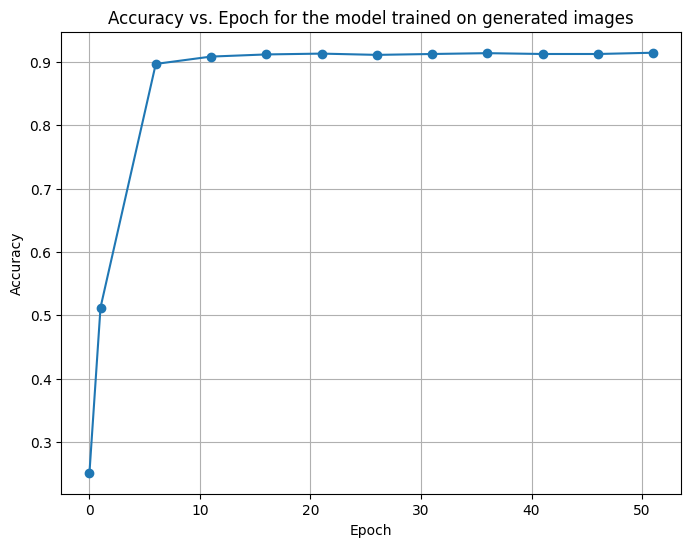

In [17]:
import matplotlib.pyplot as plt
import csv

# Read data from the CSV file
epochs = []
accuracies = []

with open('results.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        epochs.append(int(row['epoch']))
        accuracies.append(float(row['accuracy']))

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch for the model trained on generated images')
plt.grid(True)
plt.show()